<a href="https://colab.research.google.com/github/tommyj530/Learning-based-comms-system-using-autoencoder-and-CGAN/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder-Based End-to-End Communications System
ELEC825 Machine Learning and Deep Learning @ Queen's University Kingston, ON

## Training a bit-wise end-to-end communications system over the AWGN channel
We can train over Rayleigh or Rician if more appropriate 

#### Import libraries

In [ ]:
import glob
import imageio
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # Ignore if you do not have multiple GPUs

import time 
from IPython import display

In [ ]:
print(tf.__version__)

2.3.1


#### Autoencoder parameters

In [ ]:
k = 4                               # bit per autoencoder message
M = 2**k                            # total nb of autoencoder messages
n = 2                               # number of real-valued channel uses

## The Encoder / Transmitter

In [ ]:
encoder_input = tf.keras.Input(shape=(), dtype=tf.int32, name='enc_in')
one_hot = tf.one_hot(encoder_input,depth=M)
x = tf.keras.layers.Dense(128,activation="relu")(one_hot)
x = tf.keras.layers.Dense(128,activation="relu")(x)
x = tf.keras.layers.Dense(n,activation=None)(x)
encoder_output = x / tf.sqrt(tf.reduce_mean(tf.square(x)))    # batch normalization to limit average signal power to 1.0 (per complex channel use)
encoder = tf.keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_in (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
tf_op_layer_OneHot (TensorFlowO [(None, 16)]         0           enc_in[0][0]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          2176        tf_op_layer_OneHot[0][0]         
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
____________________________________________________________________________________________

Data Visualization

In [ ]:
np.arange(M,dtype=np.int32)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int32)

One-hot vector represetnation

In [ ]:
print(tf.one_hot(np.arange(M,dtype=np.int32),  16))

tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(16, 16), dtype=float32)


#### Test the transmitter
Generate signals for a batch of all possible M messages and have a look at the encoded signals

In [ ]:
x = encoder(np.arange(M,dtype=np.int32)).numpy()
print(x)
print(x.shape)

[[-0.5450809  -0.20776744]
 [-0.760642    0.17213891]
 [ 0.01583982  0.03106067]
 [-0.89933646 -0.08911037]
 [-1.1291891   0.76433265]
 [-1.7925088   1.0413537 ]
 [-0.56150365  0.6861245 ]
 [-2.4430273   0.30941683]
 [-0.02572816  0.0341364 ]
 [-2.3855467   0.7252408 ]
 [ 0.2866711   0.21592411]
 [-1.4030954  -0.4212958 ]
 [-2.1444292   0.19223277]
 [-0.00765335 -0.17435527]
 [-1.2445779  -0.42769477]
 [-1.4297171   0.53945774]]
(16, 2)


#### Complex-valued constellation diagrams

The constellation our AE uses. The constellation is optimized to reduce the performance metric (BER) during training.

In [ ]:
def plot_constellation(maxrange=None, show_labels=False):
    '''Generate a plot of the current constellation'''
    x = encoder(np.arange(M,dtype=np.int32)).numpy()
    x = np.reshape(x,[M,int(n/2),2])
    if (maxrange is None):
        maxrange = np.max(np.abs(x))
    for k in range(int(n/2)):
        image = plt.figure(figsize=(6,6))
        plt.grid(True)
        plt.xlim(-maxrange,maxrange)
        plt.ylim(-maxrange,maxrange)
        for i in range(M):       
            plt.scatter(x[i,k,0],x[i,k,1],c="black",marker='x')
            if show_labels:
                plt.annotate(str(L[i].numpy()),(x[i,k,0],x[i,k,1]),c="gray",ha='center',xytext=(0, 5),textcoords='offset points')
        image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
        image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
        image.suptitle('%d. complex symbol' % (k+1))
        plt.xlabel('Re')
        plt.ylabel('Im')
    return x, image

This is what the AE constellation looks like before training. Based on communication theory, we know that maximizing the Euclidean distance in addition to using Gray code between any two neightbouring constellation points reduces the probability of making an error.

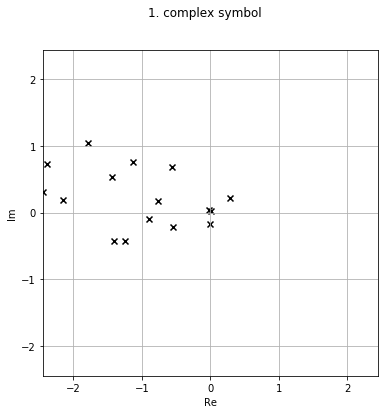

In [ ]:
plot_constellation();

#### Bit-Labeling for each AE message
Label each of the M messages with a sequence of k bit (groud-truth labels)

In [ ]:
np.binary_repr(3, width = k)[1]

'0'

In [ ]:
def get_bit_label_natural(k):
    M=2**k
    label_natural = np.zeros((M,k))

    for j in range(M):
        for i in range(k):
            label_natural[j,i] = np.binary_repr(j, width = k)[i]
    return label_natural

L = tf.cast(get_bit_label_natural(k),dtype=tf.int8)
print(L.numpy())

[[0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]
 [1 0 1 1]
 [1 1 0 0]
 [1 1 0 1]
 [1 1 1 0]
 [1 1 1 1]]


Initial constellation with labels

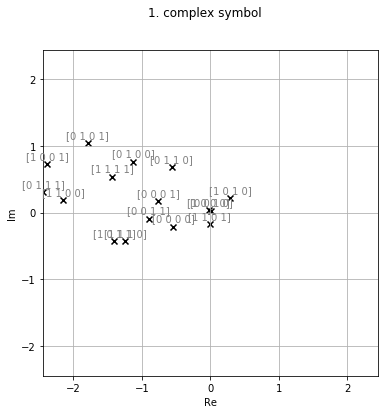

In [ ]:
plot_constellation(show_labels=True);

# The AWGN Channel 
We can replace this with other stochastic channel models e.g. Rayleigh and Rician if needed. In the second part of this project, we will train a GAN and use it as a surrogate for the real channel.

In [ ]:
def ebnodb_2_noisestd(awgn_ebno_db):
    return  1.0 / tf.sqrt(k/n * 2 * 10**(awgn_ebno_db/10.))  # noise variance per complex-valued component

def awgn_channel(x,awgn_ebno_db):
    noise_std = ebnodb_2_noisestd(awgn_ebno_db)
    return x + tf.random.normal(shape=tf.shape(x)) * tf.cast(noise_std,dtype=tf.float32)

# The Decoder / Receiver

In [ ]:
decoder_input = tf.keras.Input(shape=(n), name='dec_in')
x = tf.keras.layers.Dense(128,activation="relu")(decoder_input)
x = tf.keras.layers.Dense(128,activation="relu")(x)
decoder_output = tf.keras.layers.Dense(k,activation=None)(x)
decoder = tf.keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dec_in (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
Total params: 17,412
Trainable params: 17,412
Non-trainable params: 0
_________________________________________________________________


# Training

**Things to implement**
*   Training vs Validation Loss/Accuracy Graph
*   Early Stopping
*   Training with low EbNo vs high EbNo
*   Training with long sequences 


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
batch_size = 16
s = tf.random.uniform(shape=(batch_size,),minval=0,maxval=M,dtype=tf.int32)
print(L)
print(s)
print(tf.gather(L,s))

tf.Tensor(
[[0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]
 [1 0 1 1]
 [1 1 0 0]
 [1 1 0 1]
 [1 1 1 0]
 [1 1 1 1]], shape=(16, 4), dtype=int8)
tf.Tensor([ 6  2  8 11 13  0  0  8  7  5  5  4  5 15  0  5], shape=(16,), dtype=int32)
tf.Tensor(
[[0 1 1 0]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 1 1]
 [1 1 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 1 1 1]
 [0 1 0 1]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 1]
 [1 1 1 1]
 [0 0 0 0]
 [0 1 0 1]], shape=(16, 4), dtype=int8)


In [ ]:
tf.less([-0.2, -0.4, 0.9, 0.8],0.0)

<tf.Tensor: shape=(4,), dtype=bool, numpy=array([ True,  True, False, False])>

In [ ]:
    u_hat_hard = tf.cast(tf.less([-0.2, 0.4, -0.9, 0.8],0.0),tf.int8)
    print(u_hat_hard)

tf.Tensor([1 0 1 0], shape=(4,), dtype=int8)


In [ ]:
def autoencode(batch_size,awgn_ebno_db):
    s = tf.random.uniform(shape=(batch_size,),minval=0,maxval=M,dtype=tf.int32)
    u = tf.gather(L,s)
    
    x = encoder(s)
    y = awgn_channel(x,awgn_ebno_db)
    u_l = decoder(y)
    
    return u,u_l

@tf.function
def train_step(batch_size,awgn_ebno_db):
    
    with tf.GradientTape() as tape:
        u,u_l = autoencode(batch_size,awgn_ebno_db)
        # Loss
        loss = tf.losses.binary_crossentropy(y_true=u,y_pred=-u_l,from_logits=True)

    trainable_weights = [] + encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_weights)
    # Applying gradients for this batch
    optimizer.apply_gradients(zip(gradients, trainable_weights))
    
    return tf.reduce_mean(loss)

@tf.function
def test_step(batch_size,awgn_ebno_db):
    u,u_l = autoencode(batch_size,awgn_ebno_db)
    
    # AE Performance metrics
    u_hat_hard = tf.cast(tf.less(u_l,0.0),tf.int8)
    correct_predictions = tf.equal(u_hat_hard,u)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    ber_hard = 1.0 - accuracy
    
    return ber_hard

In [ ]:
def train(training_params, validation_params):  
    '''Training and validation loop'''
    for index, params in enumerate(training_params):
        batch_size, lr, ebnodb, iterations = params
        print('\nBatch Size: ' + str(batch_size) +
              ', Learning Rate: ' + str(lr) +
              ', EbNodB: ' + str(ebnodb) +
              ', Iterations: ' + str(iterations))

        val_size, val_ebnodb, val_steps = validation_params[index]

        for i in range(iterations):
            optimizer.learning_rate = lr
            loss = train_step(tf.constant(batch_size), tf.constant(ebnodb)).numpy()
            if (i%val_steps==0):
                ber = test_step(val_size,val_ebnodb).numpy()
                print("loss: %.3e    BER: %.3e" % (loss,ber))
    return

def ber_sim(ebnodbs, batch_size, iterations):
    '''Monte Carlo simulations of BER for a range of Eb/No
       Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
       You can average over multiple batches with small size instead.           
    '''
    BER = np.zeros_like(ebnodbs)
    for i in range(iterations):
        ber = np.array([test_step(tf.constant(batch_size), tf.constant(ebnodb)).numpy() for ebnodb in ebnodbs])
        BER = BER + ber/iterations
    return BER

def plot_ber(EbNodB, BER):
    '''Plot a BER vs SNR curve'''
    image = plt.figure(figsize=(10,8))
    plt.plot(EbNodB, BER, '-r', linewidth=2.0)
    plt.yscale('log')
    plt.xlabel('EbNo (dB)', fontsize=18)
    plt.ylabel('Bit-error rate', fontsize=18)
    plt.grid(True)
    plt.ylim([1e-5,1])
    return image


### training parameters

Here we define the SNR during training. The autoencoder will then be trained to find an optimal constellation for this specific training SNR.
Mind that this constellation might not be the optimal constellation for the total SNR range, also the receiver is only trained to demap at training SNR.

In [ ]:
train_EbNodB = -5.0
val_EbNodB = train_EbNodB

training_params = [
    #batch_size, lr, ebnodb, iterations
    [100    , 0.001, train_EbNodB, 1000],
    [1000    , 0.0001, train_EbNodB, 1000],
    [10000    , 0.0001, train_EbNodB, 1000],
    [100000    , 0.0001, train_EbNodB, 1000]
]

validation_params = [
    #batch_size, ebnodb, val_steps 
    [100000, val_EbNodB, 100],
    [100000, val_EbNodB, 100],
    [100000, val_EbNodB, 100],
    [100000, val_EbNodB, 100]
]

### start the training

In [ ]:
train(training_params,validation_params)


Batch Size: 100, Learning Rate: 0.001, EbNodB: -5.0, Iterations: 1000
loss: 6.883e-01    BER: 4.274e-01
loss: 4.934e-01    BER: 2.977e-01
loss: 5.084e-01    BER: 3.053e-01
loss: 4.988e-01    BER: 3.073e-01
loss: 5.171e-01    BER: 3.096e-01
loss: 4.837e-01    BER: 3.078e-01
loss: 5.171e-01    BER: 3.063e-01
loss: 5.021e-01    BER: 3.140e-01
loss: 5.438e-01    BER: 3.126e-01
loss: 5.188e-01    BER: 3.133e-01

Batch Size: 1000, Learning Rate: 0.0001, EbNodB: -5.0, Iterations: 1000
loss: 5.052e-01    BER: 3.114e-01
loss: 4.897e-01    BER: 3.103e-01
loss: 4.968e-01    BER: 3.128e-01
loss: 4.962e-01    BER: 3.106e-01
loss: 5.066e-01    BER: 3.111e-01
loss: 4.963e-01    BER: 3.106e-01
loss: 5.033e-01    BER: 3.108e-01
loss: 4.892e-01    BER: 3.105e-01
loss: 4.985e-01    BER: 3.120e-01
loss: 5.057e-01    BER: 3.134e-01

Batch Size: 10000, Learning Rate: 0.0001, EbNodB: -5.0, Iterations: 1000
loss: 4.984e-01    BER: 3.128e-01
loss: 4.979e-01    BER: 3.142e-01
loss: 4.947e-01    BER: 3.132e-01


# Evaluation

At first, let's have a look at the found constellation

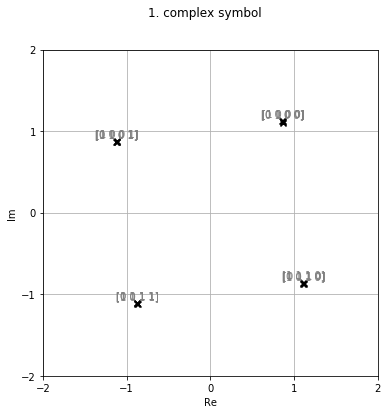

In [ ]:
plot_constellation(show_labels=True);

#### BER perfomance evaluation
Here we compare the AE's BER performance with classical baselines.
The baseline results are taken from our webdemo [Physical Layer Performance Measures - Symbol Error Rate, BER and Mutual Information](https://webdemo.inue.uni-stuttgart.de/webdemos/02_lectures/communication_3/performance_measures/).

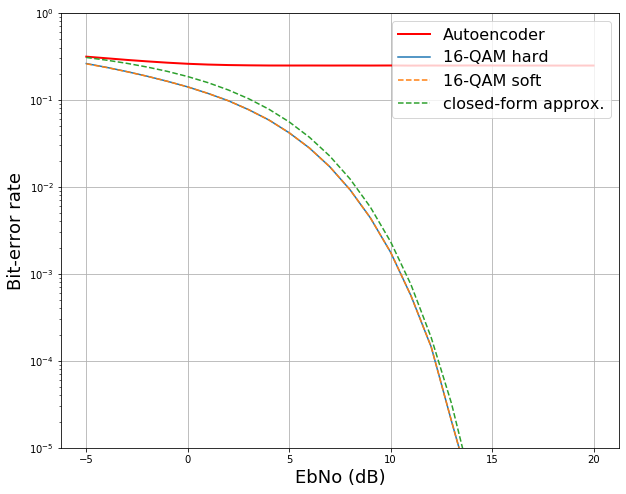

In [ ]:
# reference curves
ebnodbs_ref = np.linspace(-5,20,26)
ber_ref_hard_n2 = np.array([[2.132e-01, 1.861e-01, 1.588e-01, 1.303e-01, 1.037e-01, 7.823e-02, 5.592e-02, 3.737e-02, 2.282e-02, 1.249e-02, 5.959e-03, 2.385e-03, 7.400e-04, 2.050e-04, 3.500e-05, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.137e-01, 1.857e-01, 1.581e-01, 1.310e-01, 1.042e-01, 7.860e-02, 5.629e-02, 3.746e-02, 2.302e-02, 1.241e-02, 5.978e-03, 2.387e-03, 7.570e-04, 2.010e-04, 3.600e-05, 5.000e-06, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.713e-01, 2.474e-01, 2.231e-01, 1.966e-01, 1.697e-01, 1.426e-01, 1.152e-01, 8.909e-02, 6.482e-02, 4.411e-02, 2.738e-02, 1.539e-02, 7.492e-03, 3.011e-03, 1.000e-03, 2.537e-04, 4.100e-05, 2.667e-06, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.618e-01, 2.367e-01, 2.116e-01, 1.872e-01, 1.636e-01, 1.411e-01, 1.187e-01, 9.781e-02, 7.725e-02, 5.876e-02, 4.186e-02, 2.795e-02, 1.704e-02, 9.262e-03, 4.407e-03, 1.768e-03, 5.617e-04, 1.443e-04, 2.025e-05, 3.000e-06, 5.000e-07, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])
ber_ref_soft_n2 = np.array([[2.132e-01, 1.861e-01, 1.588e-01, 1.303e-01, 1.037e-01, 7.823e-02, 5.592e-02, 3.737e-02, 2.282e-02, 1.249e-02, 5.959e-03, 2.385e-03, 7.400e-04, 2.050e-04, 3.500e-05, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.137e-01, 1.858e-01, 1.582e-01, 1.309e-01, 1.043e-01, 7.858e-02, 5.627e-02, 3.746e-02, 2.301e-02, 1.241e-02, 5.978e-03, 2.387e-03, 7.570e-04, 2.010e-04, 3.600e-05, 5.000e-06, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.655e-01, 2.423e-01, 2.188e-01, 1.932e-01, 1.674e-01, 1.410e-01, 1.143e-01, 8.866e-02, 6.462e-02, 4.401e-02, 2.734e-02, 1.537e-02, 7.492e-03, 3.011e-03, 9.997e-04, 2.537e-04, 4.100e-05, 2.667e-06, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.600e-01, 2.356e-01, 2.110e-01, 1.869e-01, 1.635e-01, 1.410e-01, 1.187e-01, 9.781e-02, 7.725e-02, 5.876e-02, 4.186e-02, 2.795e-02, 1.704e-02, 9.262e-03, 4.407e-03, 1.768e-03, 5.617e-04, 1.443e-04, 2.025e-05, 3.000e-06, 5.000e-07, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])
ber_ref_theory_n2 = np.array([[2.132e-01, 1.861e-01, 1.584e-01, 1.306e-01, 1.038e-01, 7.865e-02, 5.628e-02, 3.751e-02, 2.288e-02, 1.250e-02, 5.954e-03, 2.388e-03, 7.727e-04, 1.909e-04, 3.363e-05, 3.872e-06, 2.613e-07, 9.006e-09, 1.333e-10, 6.810e-13, 9.124e-16, 2.267e-19, 6.759e-24, 1.396e-29, 1.001e-36, 1.044e-45],[2.132e-01, 1.861e-01, 1.584e-01, 1.306e-01, 1.038e-01, 7.865e-02, 5.628e-02, 3.751e-02, 2.288e-02, 1.250e-02, 5.954e-03, 2.388e-03, 7.727e-04, 1.909e-04, 3.363e-05, 3.872e-06, 2.613e-07, 9.006e-09, 1.333e-10, 6.810e-13, 9.124e-16, 2.267e-19, 6.759e-24, 1.396e-29, 1.001e-36, 1.044e-45],[3.491e-01, 3.162e-01, 2.814e-01, 2.452e-01, 2.081e-01, 1.712e-01, 1.355e-01, 1.023e-01, 7.282e-02, 4.821e-02, 2.917e-02, 1.578e-02, 7.423e-03, 2.931e-03, 9.298e-04, 2.241e-04, 3.827e-05, 4.239e-06, 2.724e-07, 8.827e-09, 1.209e-10, 5.603e-13, 6.640e-16, 1.414e-19, 3.470e-24, 5.611e-30],[3.075e-01, 2.863e-01, 2.633e-01, 2.387e-01, 2.127e-01, 1.855e-01, 1.578e-01, 1.301e-01, 1.032e-01, 7.816e-02, 5.586e-02, 3.716e-02, 2.262e-02, 1.233e-02, 5.854e-03, 2.339e-03, 7.529e-04, 1.849e-04, 3.231e-05, 3.684e-06, 2.456e-07, 8.334e-09, 1.210e-10, 6.030e-13, 7.832e-16, 1.872e-19]])

# autoencoder simulations
ebnodbs = np.linspace(-5,20,26)
bers = ber_sim(ebnodbs, 100000, 10);
plot_ber(ebnodbs, bers);

plt.plot(ebnodbs_ref,ber_ref_hard_n2[k-1]);
plt.plot(ebnodbs_ref,ber_ref_soft_n2[k-1],"--");
plt.plot(ebnodbs_ref,ber_ref_theory_n2[k-1],"--");

plt.legend(['Autoencoder', '%d-QAM hard' % M,'%d-QAM soft' % M, 'closed-form approx.'], prop={'size': 16}, loc='upper right');

Zoom in to the SNR region the AE was trained for:

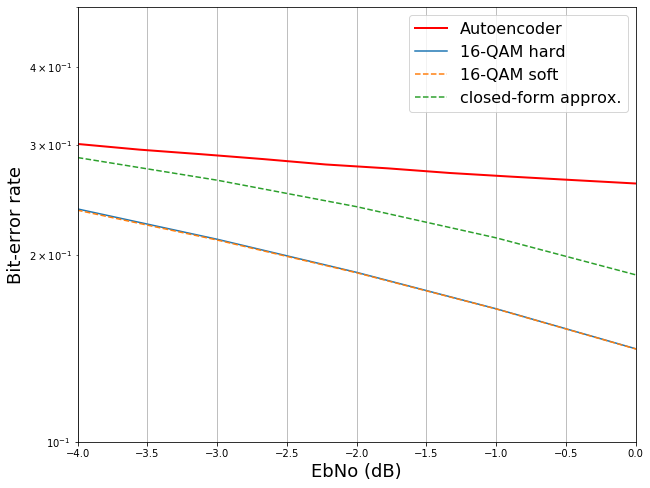

In [ ]:
# autoencoder simulations
ebnodbs = np.linspace(-4,0,10)
bers = ber_sim(ebnodbs, 100000, 10);
plot_ber(ebnodbs, bers);

plt.plot(ebnodbs_ref,ber_ref_hard_n2[k-1]);
plt.plot(ebnodbs_ref,ber_ref_soft_n2[k-1],"--");
plt.plot(ebnodbs_ref,ber_ref_theory_n2[k-1],"--");

plt.xlim([ebnodbs[0],ebnodbs[-1]])
plt.ylim([0.1,0.5])
plt.legend(['Autoencoder', '%d-QAM hard' % M,'%d-QAM soft' % M, 'closed-form approx.'], prop={'size': 16}, loc='upper right');

Training vs Validation Loss Graph
It is a standard practice to show training vs validation loss/accuracy graph to illustrate whether the learning-based model generalizes well or if it overfits/underfit. We will implement this and put it in our report

Illustrate that when trained with low EbNos, the model has diffculty learning the optimal constellation that generalizes well across a wide range of EbNos. We can interpret this as using inaccurate ground-truth labels in a supervised learning task, and the model is unable to learn the general relationship between the input and output.